### Notebook Initialization

In [2]:
#%%
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchinfo import summary

BATCH_SIZE = 64
num_classes = 10
LR = 0.01
NUM_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data to plot accuracy and loss graphs
train_losses = [None]*NUM_EPOCHS
train_accuracy = [None]*NUM_EPOCHS

test_losses = [None]*NUM_EPOCHS
test_accuracy = [None]*NUM_EPOCHS



### Data

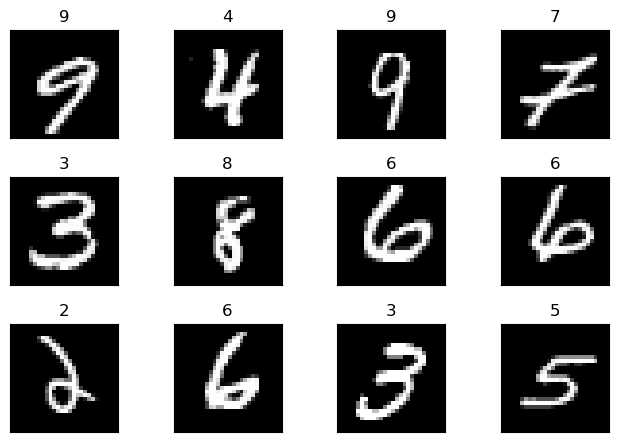

In [3]:
#%%
train_dataset = torchvision.datasets.MNIST(root = './data',train = True,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = (0.1307,), std = (0.3081,))]), download = True)
test_dataset = torchvision.datasets.MNIST(root = './data',train = False,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle = True)

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

## Model

In [4]:
#%%
class reshape(nn.Module):
	def __init__(self, pixels):
		super().__init__()
		self.pixels = pixels
		
	def forward(self, x):
		x = x.view(-1, self.pixels)
		return x
	
container = {
	"conv1": nn.Conv2d(1, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	"conv2": nn.Conv2d(32, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	
	"pool1": nn.MaxPool2d((2, 2), 2, 0),
	"conv3": nn.Conv2d(32, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	"conv4": nn.Conv2d(32, 32, (3, 3), 1, 1),
	"relu": nn.ReLU(),
	"pool2": nn.MaxPool2d((2, 2), 2, 0),
	
	"conv5": nn.Conv2d(32, 32, (3, 3), 1, 0),
	"relu": nn.ReLU(),
	
	"conv6": nn.Conv2d(32, 32, (3, 3), 1, 0),
	"relu": nn.ReLU(),
	
	"conv7": nn.Conv2d(32, 10, 3),
	
	"reshaper": reshape(10),
	"log_softmax": nn.LogSoftmax(dim=1),
}

## Train & Test Loop

In [9]:
#%%
def train(train_loader, model, error_func, optimizer, epoch_no, device=None):
	
	model.to(device)
	pbar = tqdm(train_loader)
	
	train_loss_total = 0
	correct_preds_total = 0
	for b_id, (images, labels) in enumerate(pbar):
		images,labels = images.to(device), labels.to(device)
		
		#Forward pass
		outputs = model(images)
		error_batch = error_func(outputs, labels,reduction='mean')
		
		# Backward and optimize
		optimizer.zero_grad()
		error_batch.backward()
		optimizer.step()
		
		pred_labels = outputs.argmax(dim=1, keepdim=True).squeeze()
		correct_preds_batch = torch.eq(pred_labels, labels).sum().item()
		accuracy_batch = 100.0 * correct_preds_batch / BATCH_SIZE
		pbar.set_description("Epoch %d, Batch= %d, Batch Error Value = %f, Batch Pred Acc = %f" % (epoch+1,b_id+1, error_batch.item(), accuracy_batch))
		correct_preds_total = correct_preds_total + correct_preds_batch
		train_loss_total = error_batch.item()
		if (b_id + 1) % 100 == 0:
			print("Epoch %d, Batch %d, Error Value = %f, Pred_Acc = %f" % (epoch+1,b_id+1, error_batch.item(), accuracy_batch))
	train_losses[epoch_no] = train_loss_total / len(train_loader)
	train_accuracy[epoch_no] = 100.0 * correct_preds_total / len(train_loader)
	print("Epoch %d, Final Accuracy of the network %f" % (epoch +1 , train_accuracy[epoch_no]))

def test(test_loader, model, error_func,epoch, device=None):
	torch.set_grad_enabled(False)
	
	test_loss_total = 0
	correct_preds_total = 0
	pbar = tqdm(test_loader)
	for b_id,(images, labels) in enumerate(pbar):
		images,labels = images.to(device), labels.to(device)
		
		outputs = model(images)
		error_batch = error_func(outputs, labels, reduction='mean')
		
		pred_labels = outputs.argmax(dim=1, keepdim=True).squeeze()
		correct_preds = torch.eq(pred_labels, labels).sum().item()
		accuracy_batch = correct_preds / BATCH_SIZE * 100
		
		test_loss_total = test_loss_total + error_batch.item()
		correct_preds_total += correct_preds
		
		pbar.set_description("Epoch %d, Batch= %d, Error Value = %f, Pred Acc = %f" % (epoch+1, b_id+1, error_batch.item(), accuracy_batch))
		if (b_id + 1) % 100 == 0:
			print("Epoch %d, Batch %d, Error Value = %f, Pred_Acc = %f" % (epoch+1,b_id+1, error_batch.item(), accuracy_batch))
	test_losses[epoch] = test_loss_total / len(train_loader)
	test_accuracy[epoch] = 100.0 * correct_preds_total / len(test_loader)
	print("Epoch %d, Final Accuracy of the network %f" % (epoch +1 , 100.0 * correct_preds_total / len(test_loader)))
	torch.set_grad_enabled(True)



## **Model Training**

In [10]:
#%%
model = nn.Sequential(*container.values())
error_func = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#%%

for epoch in range(NUM_EPOCHS):
	print("epoch no= ",epoch+1)
	train(train_loader, model, error_func, optimizer,epoch)
	test(train_loader, model, error_func,epoch)

epoch no=  1


Epoch 1, Batch= 103, Batch Error Value = 1.271208, Batch Pred Acc = 62.500000:  11%|█         | 102/938 [00:05<00:48, 17.16it/s]

Epoch 1, Batch 100, Error Value = 1.572333, Pred_Acc = 51.562500


Epoch 1, Batch= 203, Batch Error Value = 0.411178, Batch Pred Acc = 87.500000:  22%|██▏       | 202/938 [00:11<00:43, 16.99it/s]

Epoch 1, Batch 200, Error Value = 0.438838, Pred_Acc = 84.375000


Epoch 1, Batch= 303, Batch Error Value = 0.170074, Batch Pred Acc = 95.312500:  32%|███▏      | 302/938 [00:17<00:36, 17.63it/s]

Epoch 1, Batch 300, Error Value = 0.150293, Pred_Acc = 95.312500


Epoch 1, Batch= 403, Batch Error Value = 0.443028, Batch Pred Acc = 93.750000:  43%|████▎     | 402/938 [00:23<00:30, 17.58it/s] 

Epoch 1, Batch 400, Error Value = 0.089265, Pred_Acc = 95.312500


Epoch 1, Batch= 503, Batch Error Value = 0.121186, Batch Pred Acc = 96.875000:  54%|█████▎    | 502/938 [00:28<00:24, 17.72it/s] 

Epoch 1, Batch 500, Error Value = 0.133406, Pred_Acc = 92.187500


Epoch 1, Batch= 603, Batch Error Value = 0.213365, Batch Pred Acc = 92.187500:  64%|██████▍   | 602/938 [00:34<00:18, 17.69it/s] 

Epoch 1, Batch 600, Error Value = 0.095269, Pred_Acc = 95.312500


Epoch 1, Batch= 703, Batch Error Value = 0.102966, Batch Pred Acc = 95.312500:  75%|███████▍  | 702/938 [00:40<00:13, 17.56it/s] 

Epoch 1, Batch 700, Error Value = 0.114629, Pred_Acc = 95.312500


Epoch 1, Batch= 803, Batch Error Value = 0.135438, Batch Pred Acc = 95.312500:  86%|████████▌ | 802/938 [00:45<00:07, 17.73it/s] 

Epoch 1, Batch 800, Error Value = 0.191169, Pred_Acc = 90.625000


Epoch 1, Batch= 903, Batch Error Value = 0.152004, Batch Pred Acc = 95.312500:  96%|█████████▌| 902/938 [00:51<00:02, 17.86it/s] 

Epoch 1, Batch 900, Error Value = 0.048235, Pred_Acc = 98.437500


Epoch 1, Batch= 938, Batch Error Value = 0.149054, Batch Pred Acc = 48.437500: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s] 


Epoch 1, Final Accuracy of the network 5429.317697


Epoch 1, Batch= 108, Error Value = 0.100636, Pred Acc = 96.875000:  11%|█         | 105/938 [00:02<00:18, 44.04it/s]

Epoch 1, Batch 100, Error Value = 0.107457, Pred_Acc = 95.312500


Epoch 1, Batch= 209, Error Value = 0.148960, Pred Acc = 95.312500:  22%|██▏       | 205/938 [00:04<00:15, 48.28it/s] 

Epoch 1, Batch 200, Error Value = 0.034129, Pred_Acc = 100.000000


Epoch 1, Batch= 309, Error Value = 0.075338, Pred Acc = 98.437500:  33%|███▎      | 305/938 [00:06<00:13, 47.66it/s] 

Epoch 1, Batch 300, Error Value = 0.041860, Pred_Acc = 100.000000


Epoch 1, Batch= 409, Error Value = 0.210006, Pred Acc = 95.312500:  43%|████▎     | 405/938 [00:08<00:11, 45.07it/s] 

Epoch 1, Batch 400, Error Value = 0.154576, Pred_Acc = 92.187500


Epoch 1, Batch= 509, Error Value = 0.080315, Pred Acc = 98.437500:  54%|█████▍    | 505/938 [00:10<00:08, 48.54it/s] 

Epoch 1, Batch 500, Error Value = 0.132394, Pred_Acc = 95.312500


Epoch 1, Batch= 609, Error Value = 0.069426, Pred Acc = 98.437500:  64%|██████▍   | 605/938 [00:12<00:07, 47.35it/s] 

Epoch 1, Batch 600, Error Value = 0.052114, Pred_Acc = 98.437500


Epoch 1, Batch= 708, Error Value = 0.056488, Pred Acc = 96.875000:  75%|███████▌  | 705/938 [00:15<00:05, 44.74it/s] 

Epoch 1, Batch 700, Error Value = 0.152599, Pred_Acc = 93.750000


Epoch 1, Batch= 809, Error Value = 0.209693, Pred Acc = 92.187500:  86%|████████▌ | 805/938 [00:17<00:02, 48.01it/s] 

Epoch 1, Batch 800, Error Value = 0.056578, Pred_Acc = 96.875000


Epoch 1, Batch= 909, Error Value = 0.062497, Pred Acc = 96.875000:  96%|█████████▋| 905/938 [00:19<00:00, 48.11it/s] 

Epoch 1, Batch 900, Error Value = 0.024873, Pred_Acc = 100.000000


Epoch 1, Batch= 938, Error Value = 0.042501, Pred Acc = 50.000000: 100%|██████████| 938/938 [00:19<00:00, 46.94it/s] 


NameError: name 'epoch_no' is not defined

## Train Test Loss Curves

In [ ]:
#%%
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")